In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix , classification_report , accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense , Dropout , LSTM , Input , Embedding , Bidirectional , Softmax , Dot , RepeatVector , Concatenate , BatchNormalization

## Importing Data
---

In [ ]:
TRAIN_DATA_PATH = './Dataset/Train.csv'
TEST_DATA_PATH = './Dataset/Test.csv'
MAPPING_EMOJIS_PATH = './Dataset/Mapping.csv'

In [ ]:
# Get emoji mappings
emoji_mappings_data = pd.read_csv(MAPPING_EMOJIS_PATH)
emoji_mappings_data.drop(columns = ['Unnamed: 0'], axis = 1 , inplace = True)
emoji_mappings = emoji_mappings_data.to_dict()['emoticons']

In [ ]:
print(emoji_mappings)

{0: '😜', 1: '📸', 2: '😍', 3: '😂', 4: '😉', 5: '🎄', 6: '📷', 7: '🔥', 8: '😘', 9: '❤', 10: '😁', 11: '🇺🇸', 12: '☀', 13: '✨', 14: '💙', 15: '💕', 16: '😎', 17: '😊', 18: '💜', 19: '💯'}


In [ ]:
# Fetch the train data
data = pd.read_csv(TRAIN_DATA_PATH)
data.drop(columns = ['Unnamed: 0'] , axis = 1 , inplace = True)
data

TEXT  Label
0      Vacation wasted ! #vacation2017 #photobomb #ti...      0
1      Oh Wynwood, you’re so funny! : @user #Wynwood ...      1
2      Been friends since 7th grade. Look at us now w...      2
3      This is what it looks like when someone loves ...      3
4      RT @user this white family was invited to a Bl...      3
...                                                  ...    ...
69995  Yes, I call Galina "my Bubie" Go follow my bea...      3
69996    I SEA you, Seattle @ Ballard Seafood Festival\n     16
69997  If one of my daughters is wearing this and ask...      2
69998  Guess who whoop people on THEIR homecoming?! #...      3
69999  We Love you Robbie @ Heritage Memorial Cemeter...     14

[70000 rows x 2 columns]

In [ ]:
# Fetch the Glove Vector representations from archive.zip (Run this once to extract)
import zipfile
import os

zip_file_path = './Dataset'
with zipfile.ZipFile(os.path.join(zip_file_path , 'archive.zip')) as file:
    file.extractall(zip_file_path)

In [ ]:
GLOVEVEC_PATH = './Dataset/glove.6B.50d.txt'
# We have 400k words and each word is represented as a 50 dimensional vector
WORD_TO_VEC = {}
with open(GLOVEVEC_PATH , 'rt') as file:
    for line in file:
        line = line.split()
        word = line[0]
        vector = np.array(line[1:] , dtype = np.float32)
        WORD_TO_VEC[word] = vector

In [ ]:
# Let's split the data into train and validation sets
labels = data['Label']
labels = to_categorical(labels)
data = data['TEXT']

## MODEL-2
---
* ### Embedding Layer
* ### LSTM based Neural Network

In [ ]:
# find the maximum length of a sentence in the train data
max_length = max(list(map(lambda x: len(x.split()) , data))) # 34

> Max length is 34 . Now any sentence of `length > 34` will be truncated and any with `length < 34` will be padded with Zero vectors

In [ ]:
WORD_TO_INDICES = {}
for ind , word in enumerate(list(WORD_TO_VEC.keys())):
  WORD_TO_INDICES[word] = ind + 1

In [ ]:
def sentence_to_indices(batch , max_length):
  '''
    Arguments:
      batch : batch of data (m)
      max_length : maximum length of sentence ~ 34

    Return:
      X : batch of data where each word is converted to indices within the vocabulory
  '''

  m = batch.shape[0]
  X = np.zeros((m , max_length))

  for i , sentence in enumerate(batch):
    words = sentence.split()
    j = 0
    for word in words:
      if word.lower() in WORD_TO_VEC.keys():
        X[i][j] = WORD_TO_INDICES[word.lower()]
      j += 1

  return X

In [ ]:
def pretrained_embedding_layer(WORD_TO_VEC , WORD_TO_INDICES):
  '''
    Arguments:
      WORD_TO_VEC : dictionary mapping words to their vector embeddings
      WORD_TO INDICES : dictionary mapping words to their indices in the vocabulary

    Return:
      embedding_layer: pretrained embedding layer
  '''
  vocab_size = len(WORD_TO_VEC) + 1 # for unknown word
  embd_size = 50

  embedding_matrix = np.zeros((vocab_size , embd_size))

  for word , ind in WORD_TO_INDICES.items():
    embedding_matrix[ind , :] = WORD_TO_VEC[word]

  embedding_layer = Embedding(input_dim = vocab_size , output_dim = embd_size , trainable = False)
  embedding_layer.build((None , ))
  embedding_layer.set_weights([embedding_matrix])

  return embedding_layer

In [ ]:
def custom_model(WORD_TO_VEC , WORD_TO_INDICES , max_length):
  '''
    Arguments:
      WORD_TO_VEC : dictionary mapping words to their vector embeddings
      WORD_TO INDICES : dictionary mapping words to their indices in the vocabulary
      max_length : maximum length of sentence ~ 34

    Return:
      model: Custom Model
  '''
  inputs = Input(shape = (max_length,))

  embedding_layer = pretrained_embedding_layer(WORD_TO_VEC , WORD_TO_INDICES)
  x = embedding_layer(inputs)

  x = LSTM(units = 256 , return_sequences = True)(x)
  x = Dropout(rate = 0.3)(x)
  x = LSTM(units = 256 , return_sequences = True)(x)
  x = Dropout(rate = 0.3)(x)
  x = LSTM(units = 128)(x)
  x = Dropout(rate = 0.3)(x)
  x = Dense(64 , activation = 'relu')(x)
  x = Dense(32 , activation = 'relu')(x)
  outputs = Dense(units = 20 , activation = 'softmax')(x)

  model = tf.keras.models.Model(inputs = inputs , outputs = outputs)
  return model

In [ ]:
model = custom_model(WORD_TO_VEC , WORD_TO_INDICES , max_length)

In [ ]:
model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 34)]              0         
                                                                 
 embedding_19 (Embedding)    (None, 34, 50)            20000050  
                                                                 
 lstm_51 (LSTM)              (None, 34, 256)           314368    
                                                                 
 dropout_31 (Dropout)        (None, 34, 256)           0         
                                                                 
 lstm_52 (LSTM)              (None, 34, 256)           525312    
                                                                 
 dropout_32 (Dropout)        (None, 34, 256)           0         
                                                                 
 lstm_53 (LSTM)              (None, 128)               197

In [ ]:
x_train , x_val , y_train , y_val = train_test_split(data, labels, test_size = 0.2 , shuffle = True)
x_train , x_test , y_train , y_test = train_test_split(x_train , y_train , test_size = 0.1 , shuffle = True)

In [ ]:
x_train = sentence_to_indices(x_train , max_length)
x_val = sentence_to_indices(x_val , max_length)

In [ ]:
EPOCHS = 100
BATCH_SIZE = 128

EarlyStopping = tf.keras.callbacks.EarlyStopping(patience = 10)
model.compile(loss = 'categorical_crossentropy' , optimizer = 'Adam' , metrics = ['accuracy'])
history = model.fit(x_train , y_train , validation_data = [x_val , y_val] , validation_batch_size = 64 ,batch_size = BATCH_SIZE , epochs = EPOCHS , callbacks = [EarlyStopping])

Epoch 1/100
394/394 [==============================] - 75s 176ms/step - loss: 0.4278 - accuracy: 0.8825 - val_loss: 0.5018 - val_accuracy: 0.8682
Epoch 2/100
394/394 [==============================] - 7s 18ms/step - loss: 0.3210 - accuracy: 0.9090 - val_loss: 0.4407 - val_accuracy: 0.8869
Epoch 3/100
394/394 [==============================] - 9s 23ms/step - loss: 0.2876 - accuracy: 0.9169 - val_loss: 0.4124 - val_accuracy: 0.8940
Epoch 4/100
394/394 [==============================] - 7s 19ms/step - loss: 0.2622 - accuracy: 0.9226 - val_loss: 0.3857 - val_accuracy: 0.9034
Epoch 5/100
394/394 [==============================] - 8s 19ms/step - loss: 0.2500 - accuracy: 0.9266 - val_loss: 0.3654 - val_accuracy: 0.9038
Epoch 6/100
394/394 [==============================] - 7s 19ms/step - loss: 0.2376 - accuracy: 0.9296 - val_loss: 0.3555 - val_accuracy: 0.9121
Epoch 7/100
394/394 [==============================] - 8s 20ms/step - loss: 0.2308 - accuracy: 0.9307 - val_loss: 0.3719 - val_accurac

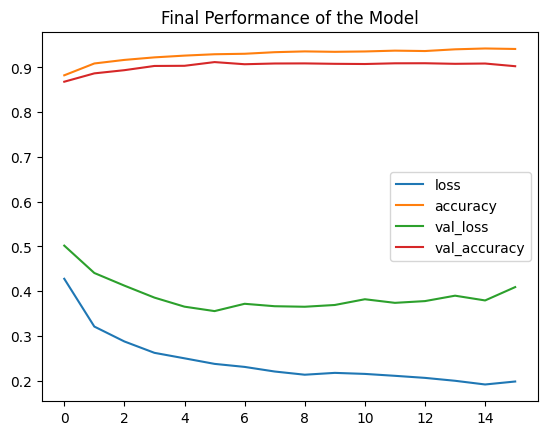

In [ ]:
ax = pd.DataFrame(history.history).plot()
fig = ax.get_figure()
ax.set_title('Final Performance of the Model')
fig.savefig('Final_performance')

In [ ]:
model.save('Lstm_model2.keras')

## Saving the Model and Analysing its performance

In [ ]:
MODEL = tf.keras.models.load_model('./model2/Lstm_model2.keras')

In [ ]:
# Now lets take max of the prediction and compare , For which run
def get_predictions(MODEL , x):
  prediction = MODEL.predict(x)
  prediction = np.argmax(prediction , axis = 1)
  return prediction

In [ ]:
original = np.argmax(y_test , axis = 1)
prediction = get_predictions(MODEL , sentence_to_indices(x_test , max_length))
report = classification_report(original , prediction)

In [ ]:
print('\t\t\t Classification Report \n' + '--'*40)
print(report)

			 Classification Report 
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       119
           1       0.91      0.92      0.91       216
           2       0.90      0.93      0.91       580
           3       0.96      0.93      0.95       545
           4       0.95      0.91      0.93       175
           5       0.91      0.97      0.94       150
           6       0.92      0.91      0.91       175
           7       0.95      0.93      0.94       329
           8       0.98      0.87      0.92       177
           9       0.93      0.95      0.94      1165
          10       0.89      0.94      0.92       163
          11       0.91      0.90      0.91       191
          12       0.92      0.93      0.93       151
          13       0.94      0.96      0.95       259
          14       0.93      0.90      0.91       200
          15       0.92    

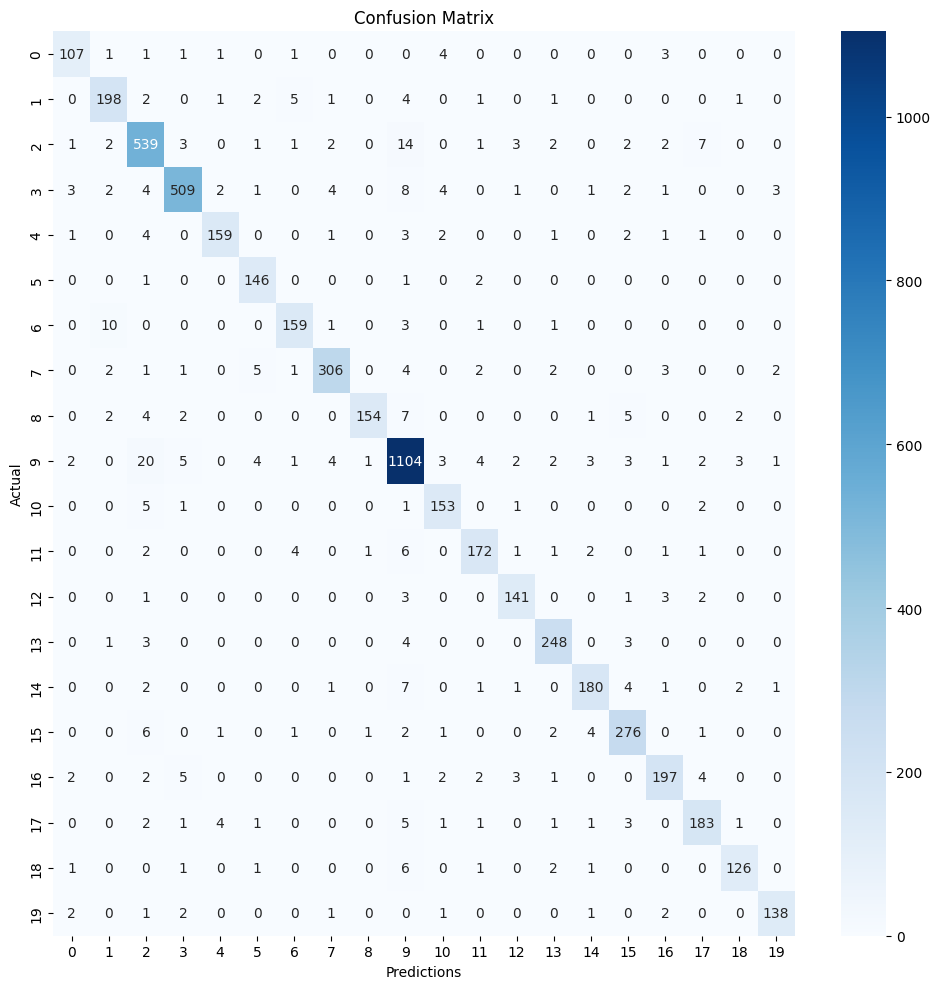

In [ ]:
mat = confusion_matrix(original , prediction)
plt.figure(figsize = (10 , 10))
sns.heatmap(mat , annot = True ,fmt = 'd', cmap = 'Blues')
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout(h_pad = .5 , w_pad = .5)
plt.savefig('Confusion_matrix')

In [ ]:
emoji_mappings[9] , emoji_mappings[2]
# There is mis-prediction in these classes as they are used for quite similar purpose

('❤', '😍')

In [ ]:
train_prediction = get_predictions(MODEL , x_train)
train_original = np.argmax(y_train , axis = 1)
print(f'The train accuracy of the model is : {accuracy_score(train_original , train_prediction)}')
print(f'The test accuracy of the model is : {accuracy_score(original , prediction)}')

1575/1575 [==============================] - 152s 97ms/step
The train accuracy of the model is : 0.9342063492063492
The test accuracy of the model is : 0.9276785714285715


In [ ]:
# Lets try it out over some unknown test_sentences
unknown_data = pd.read_csv(TEST_DATA_PATH)
unknown_sentences = unknown_data['TEXT']
total_examples = len(unknown_sentences)

In [ ]:
indices = np.random.choice(total_examples , size = 10)
test_examples = unknown_sentences.iloc[indices].to_numpy()

test_examples = sentence_to_indices(test_examples , max_length)
predictions = np.argmax(MODEL.predict(test_examples) , axis = 1)

print('--'*20)
for i , sentence in enumerate(unknown_sentences.iloc[indices]):
  print(f"{sentence} : {emoji_mappings[predictions[i]]}")

1/1 [==============================] - 0s 92ms/step
----------------------------------------
I love the smell of pate sucree in the evening. @ Desserts To Die For
 : 😘
Feel free to be alive #SantaBarbara #DanishVillage #LosAngeles #California #CarShow @ Santa…
 : 🇺🇸
This is about take 15 in 20 mins #festivaloflights with these babes…
 : ✨
Adventuring in Yosemite. #yosemitenationalpark #throwback : edgarsirr @ Yosemite National Park
 : 📸
A kiss for the love of my life @user and I played New love interests on a project for…
 : ❤
It's gonna be a good night! What a great way to start my birthday month!! Finally I'm…
 : 😊
Das Love ️ goodamerican @ Smashbox Studios
 : 💕
This is only the beginning #1month ️ @ Miami Design District
 : ✨
️ ️ ️ MEETING ON CAPITOL HILL TODAY ️ ️ ️ ️ #hahaPaper #PresidentialPaper #CongressmanPaper @user
 : 🇺🇸
Having both my boys home = Love ️ @user natecroley @ Pigeon…
 : ❤
